In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/allstate-claims-severity/train.csv.zip
/kaggle/input/allstate-claims-severity/test.csv
/kaggle/input/allstate-claims-severity/sample_submission.csv
/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/test.csv.zip
/kaggle/input/allstate-claims-severity/sample_submission.csv.zip


In [2]:
#### Import Dependencies
%matplotlib inline
#### Start Python Imports
import math, time, random, datetime
#### Data Manipulation
import numpy as np
import pandas as pd
#### Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

#### Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#### Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

##### Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd 
train = pd.read_csv("../input/allstate-claims-severity/train.csv")
test = pd.read_csv("../input/allstate-claims-severity/test.csv")

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
#Understand the data
print(train.shape)
print(test.shape)

(188318, 132)
(125546, 131)


In [5]:
# Save the test id for later submission 
# and drop the id from train and test. As id is unique for all rows and don't carry any information 
test_id = test["id"]
test.drop("id", axis = 1, inplace = True)
train.drop("id", axis = 1, inplace = True)
print(train.loss.describe())
print("")
print("The loss/target skewness : ",train.loss.skew())

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

The loss/target skewness :  3.7949583775378604


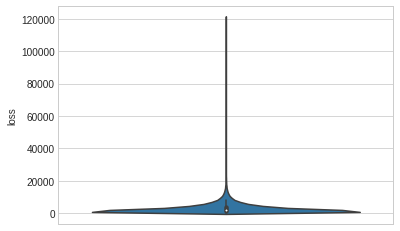

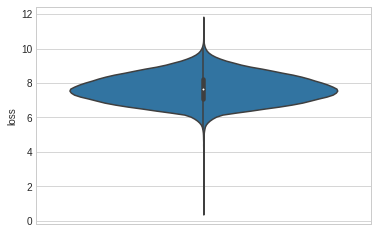

In [6]:
# since the skewness of loss is about 3, which is higher. Hence it should be corrected. 
#I have choosen to go with log1p

#Before skew correction 
sns.violinplot(data=train,y="loss")  
plt.show()

train["loss"] = np.log1p(train["loss"])

#visualize the transformed column
sns.violinplot(data=train,y="loss")  
plt.show()

In [7]:
train.loss.describe()

count    188318.000000
mean          7.685908
std           0.811309
min           0.512824
25%           7.094617
50%           7.657552
75%           8.259729
max          11.703655
Name: loss, dtype: float64

#### there is no missing value issue with data 

In [8]:
data = train.copy()
valid = test.copy()
del train
del test

In [9]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(len(object_cols))
print(object_cols)

Categorical variables:
116
['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 

#### All the categorical features should be one hot encoded.... 

In [10]:
#combined the train and test so that get dummies can be applied on all at the same time. 
## But at the same time elimination due to correlation should be considered only of from train data. 
mergedata = data.append(valid)

In [11]:
print(mergedata.shape)
print(valid.shape)
print(len(data))
print(len(valid))

(313864, 131)
(125546, 130)
188318
125546


### before doing one hot encoding using get dummies, 1] we need to remove highly mutual correlated features(one of the pair), 2] also the features with less correlation with the target.                                                  3] Then we need to remove the data that isn't properly distrubuted. 

In [12]:
#missingno.matrix(valid, figsize = (30,12))
# no missings..

In [13]:
#remove the one of the pair columns which have higher abs correlation 
data_corr = data.corr()
listOfFeatures = [i for i in data_corr]
setOfDroppedFeatures = set() 
for i in range(len(listOfFeatures)) :
    for j in range(i+1,len(listOfFeatures)): #Avoid repetitions 
        feature1=listOfFeatures[i]
        feature2=listOfFeatures[j]
        if abs(data_corr[feature1][feature2]) > 0.8: #If the correlation between the features is > 0.8
            setOfDroppedFeatures.add(feature1) 

In [14]:
mergedata = mergedata.drop(setOfDroppedFeatures, axis=1)

##### Now the correlation with the target 

In [15]:
s = (data.dtypes != 'object')
non_object_cols = list(s[s].index)
non_object_cols = [ col for col in non_object_cols if col not in setOfDroppedFeatures ]
print(len(non_object_cols))

12


In [16]:
nonCorrelatedWithOutput = [column for column in non_object_cols if abs(data[column].corr(data["loss"])) < 0.025]
print(len(nonCorrelatedWithOutput))
nonCorrelatedWithOutput

4


['cont5', 'cont9', 'cont10', 'cont13']

In [17]:
mergedata = mergedata.drop(nonCorrelatedWithOutput, axis=1)

### Non correlated cols are removed...

In [18]:
mergedata.shape

(313864, 124)

![](http://)### By observing the distrubutions(very uneven), mey be we should drop some of the features. 

In [19]:
# #uncomment if want to see the visualizatio of distribution (takes time)

# #names of all the columns
# cols = data.columns

# #Plot count plot for all attributes in a 29x4 grid
# n_cols = 4
# n_rows = 29
# for i in range(n_rows):
#     fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(12, 8))
#     for j in range(n_cols):
#         sns.countplot(x=cols[i*n_cols+j], data=data, ax=ax[j])


In [20]:
# cols taken from the visualization plots.
# to-do: find out generic method to do the same. 
unbalanced_cols = ['cat15','cat18','cat20','cat21','cat22','cat33','cat35','cat48','cat56','cat58',
                   'cat59','cat60','cat62','cat63','cat64','cat67','cat68','cat69','cat70','cat77']

In [21]:
mergedata = mergedata.drop(unbalanced_cols, axis=1)
print(mergedata.shape)

(313864, 104)


### Now one hot encoding!!

In [22]:
mergedata_ohe = pd.get_dummies(mergedata)
mergedata_ohe.shape

(313864, 1142)

In [23]:
# seperate the train and test from mergedata
trainLen = len(data)
print("train len : ", trainLen)
train_ohe = mergedata_ohe.iloc[:trainLen]
test_ohe = mergedata_ohe.iloc[trainLen:]

del mergedata_ohe
del data
del valid

print(train_ohe.shape)
print(test_ohe.shape)

train len :  188318
(188318, 1142)
(125546, 1142)


In [24]:
print(test_ohe.loss.isnull().sum())
# We should remove the extra added loss column to the test data
test_ohe = test_ohe.drop("loss", axis = 1)

125546


### Done with the encoding and EDA so far. Will have to check with different  alternatives : 1] with out dropping unbalanced data. 2] without the skew fixing  

### *** let's try ML now

In [25]:
#Build and fit the model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, Ridge
import xgboost as xgb # XGBoost implementation
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0007, random_state=1))
ridge = make_pipeline(RobustScaler(), Ridge(alpha =20, random_state=42))

In [26]:
X_train = train_ohe.drop("loss", axis = 1)
Y_train = train_ohe["loss"]
print(X_train.shape)
print(Y_train.shape)
del train_ohe

(188318, 1141)
(188318,)


In [27]:
## lasso 
# lasso.fit(X_train, y_train)
# test_y_log = lasso.predict(test_ohe)
# test_y = np.exp(1)**test_y_log

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, train_size=.90,random_state=2016)


RANDOM_STATE = 2016
#'seed': RANDOM_STATE,
params = {
    'min_child_weight': 1,
    'eta': 0.03,
    'colsample_bytree': 0.5,
    'max_depth': 12,
    'subsample': 0.8,
    'alpha': 1,
    'seed': RANDOM_STATE,
    'gamma': 1.5,
    'silent': 1,
    'verbose_eval': True,
    'nthread':7,
    'base_score':7.76
}



xgtrain = xgb.DMatrix(x_train, label=y_train)
xgval = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [ (xgtrain,'train'),(xgval,'eval')]

model = xgb.train(params, xgtrain,300, watchlist,verbose_eval=True)

del xgtrain
del xgval
xgtest = xgb.DMatrix(test_ohe)
test_y_log = model.predict(xgtest)
test_y = np.exp(1)**test_y_log

[0]	train-rmse:0.803891	eval-rmse:0.798921
[1]	train-rmse:0.793599	eval-rmse:0.789022
[2]	train-rmse:0.783078	eval-rmse:0.778837
[3]	train-rmse:0.773217	eval-rmse:0.769347
[4]	train-rmse:0.763327	eval-rmse:0.759758
[5]	train-rmse:0.753726	eval-rmse:0.75063
[6]	train-rmse:0.744794	eval-rmse:0.742198
[7]	train-rmse:0.736444	eval-rmse:0.734235
[8]	train-rmse:0.728168	eval-rmse:0.726356
[9]	train-rmse:0.719972	eval-rmse:0.71854
[10]	train-rmse:0.712282	eval-rmse:0.711291
[11]	train-rmse:0.704743	eval-rmse:0.704252
[12]	train-rmse:0.697701	eval-rmse:0.697601
[13]	train-rmse:0.690952	eval-rmse:0.691232
[14]	train-rmse:0.684381	eval-rmse:0.685148
[15]	train-rmse:0.678252	eval-rmse:0.67936
[16]	train-rmse:0.672439	eval-rmse:0.673908
[17]	train-rmse:0.666776	eval-rmse:0.66863
[18]	train-rmse:0.661132	eval-rmse:0.663438
[19]	train-rmse:0.655916	eval-rmse:0.658651
[20]	train-rmse:0.650948	eval-rmse:0.654039
[21]	train-rmse:0.645981	eval-rmse:0.649467
[22]	train-rmse:0.641428	eval-rmse:0.64528
[23

In [29]:
del X_train
del y_train

In [30]:
submission = pd.DataFrame()
submission["id"] = test_id
print(test_y.shape)
print(test_id.shape)

submission["loss"] = test_y
submission.to_csv("submission_svm_l.csv", index=False)

(125546,)
(125546,)


In [31]:
# score is : 1126.77